In [528]:
"""
AI Usage Statement (Han Chen)
Tools Used: ChatGPT
    - Usage: RoC Curve implementation, Graphing
    - Verification: Gave Chat the algorithm and only had it produce the code based on my instruction; manually input the code
Prohibited Use Compliance: Confirmed

This script is modifed based on Craig's autoencoder. 
"""

"\nAI Usage Statement (Han Chen)\nTools Used: ChatGPT\n    - Usage: RoC Curve implementation, Graphing\n    - Verification: Gave Chat the algorithm and only had it produce the code based on my instruction; manually input the code\nProhibited Use Compliance: Confirmed\n\nThis script is modifed based on Craig's autoencoder. \n"

In [529]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc
from keras import layers, regularizers, callbacks, Sequential, models
import joblib
import pickle


In [530]:
DATA_DIR = "./processed_friday_data"

train_df = pd.read_csv(f"{DATA_DIR}/X_train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/X_val.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test   = pd.read_csv(f"{DATA_DIR}/y_test.csv").iloc[:, 0]
X_val_mix = val_df.drop(columns=["Label"])
Y_val_mix = val_df["Label"]

# collapse all non-benign labels to generic “Attack”
y_test_bin = (y_test != "Benign").astype(int).values   # 0 = Benign, 1 = Attack
val_labels_bin = (Y_val_mix != "Benign").astype(int).values


In [531]:
train_benign = train_df[train_df["Label"] == "Benign"]
val_benign   = val_df  [val_df  ["Label"] == "Benign"]

X_train_raw = train_benign.drop(columns=["Label"]).values
X_val_raw   = val_benign.drop(columns=["Label"]).values
X_test_raw  = test_df.values
X_val_mix_raw = X_val_mix.values


In [532]:
print("Handle infinite values")
X_train_raw[np.isinf(X_train_raw)] = np.nan
X_val_raw[np.isinf(X_val_raw)] = np.nan
X_test_raw[np.isinf(X_test_raw)] = np.nan
X_val_mix_raw[np.isinf(X_val_mix)] = np.nan

imp = SimpleImputer(strategy="median").fit(X_train_raw)
X_train_imp = imp.transform(X_train_raw)
X_val_imp   = imp.transform(X_val_raw)
X_test_imp  = imp.transform(X_test_raw)
X_val_mix_imp  = imp.transform(X_val_mix_raw)

scaler = MinMaxScaler().fit(X_train_imp)
X_train = scaler.transform(X_train_imp)
X_val   = scaler.transform(X_val_imp)
X_test  = scaler.transform(X_test_imp)
X_val_mix = scaler.transform(X_val_mix_imp)
print(f"Train shape: {X_train.shape}   Val: {X_val.shape}   Test: {X_test.shape}    Val_B+M: {X_val_mix.shape}")


Handle infinite values
Train shape: (104233, 49)   Val: (4494, 49)   Test: (60330, 49)    Val_B+M: (6704, 49)


In [ ]:
input_dim = X_train.shape[1]  

denoise_auto = Sequential([
    layers.Input((input_dim,)),
    layers.Dense(32, activation="relu"),
    layers.GaussianNoise(0.125, seed=520),          # add Gaussian noise (std=0.025)
    layers.Dense(16, activation="relu",
                 activity_regularizer=regularizers.l1(1e-5)),
    layers.Dense(4, activation="relu"),  
    layers.Dense(16, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(input_dim, activation="linear"),
], name="denoising_autoencoder") 

denoise_auto.compile(optimizer="adam", loss="mse")
denoise_auto.summary()

early = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
history = denoise_auto.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=300,
    batch_size=1024,
    shuffle=True,
    callbacks=[early],
    verbose=2
)


Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_606 (Dense)               │ (None, 32)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_95               │ (None, 32)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_607 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_608 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_609 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_610 (Dense)               │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_611 (Dense)               │ (None, 49)             │         1,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,437 (17.33 KB)

 Trainable params: 4,437 (17.33 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
102/102 - 1s - 8ms/step - loss: 0.0726 - val_loss: 0.0387
Epoch 2/300
102/102 - 0s - 1ms/step - loss: 0.0341 - val_loss: 0.0287
Epoch 3/300
102/102 - 0s - 1ms/step - loss: 0.0269 - val_loss: 0.0247
Epoch 4/300
102/102 - 0s - 1ms/step - loss: 0.0235 - val_loss: 0.0211
Epoch 5/300
102/102 - 0s - 1ms/step - loss: 0.0203 - val_loss: 0.0185
Epoch 6/300
102/102 - 0s - 1ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 7/300
102/102 - 0s - 1ms/step - loss: 0.0168 - val_loss: 0.0159
Epoch 8/300
102/102 - 0s - 1ms/step - loss: 0.0161 - val_loss: 0.0154
Epoch 9/300
102/102 - 0s - 1ms/step - loss: 0.0156 - val_loss: 0.0148
Epoch 10/300
102/102 - 0s - 1ms/step - loss: 0.0148 - val_loss: 0.0137
Epoch 11/300
102/102 - 0s - 1ms/step - loss: 0.0136 - val_loss: 0.0125
Epoch 12/300
102/102 - 0s - 1ms/step - loss: 0.0126 - val_loss: 0.0115
Epoch 13/300
102/102 - 0s - 1ms/step - loss: 0.0118 - val_loss: 0.0108
Epoch 14/300
102/102 - 0s - 1ms/step - loss: 0.0110 - val_loss: 0.0100
Epoch 15/300
10

210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
[ROC F1] Best threshold: 0.001152 with F1: 0.680
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step


Model saved as 'denoising_autoencoder_model.h5'

Classification Report (Benign = 0, Attack = 1):
              precision    recall  f1-score   support

           0      0.982     0.557     0.711      4494
           1      0.521     0.980     0.680      2210

    accuracy                          0.696      6704
   macro avg      0.752     0.768     0.695      6704
weighted avg      0.830     0.696     0.700      6704


Readable Confusion Matrix:
                    Predicted: Benign (0)  Predicted: Attack (1)
Actual: Benign (0)                   2501                   1993
Actual: Attack (1)                     45                   2165


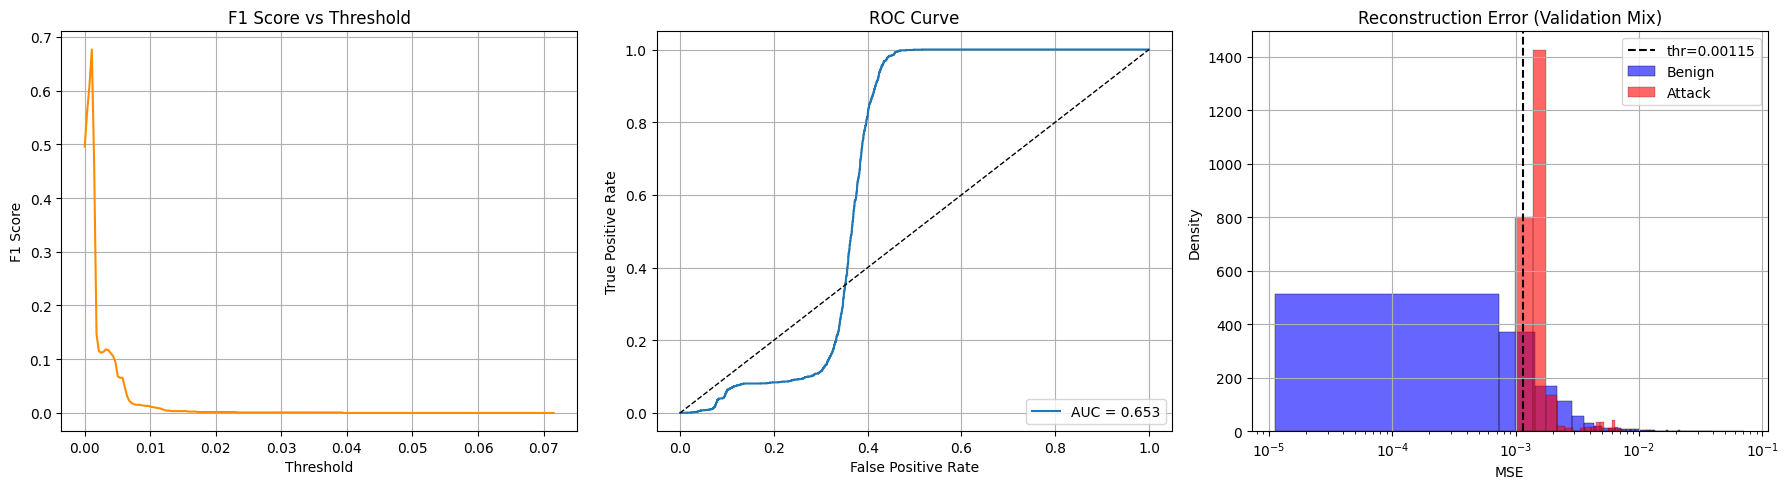

In [534]:

X_val_mix[np.isinf(X_val_mix)] = np.nan

ben_sample = X_val_mix[val_labels_bin == 0][:10000]
atk_sample = X_val_mix[val_labels_bin == 1][:10000]
mix_X = np.vstack([ben_sample, atk_sample])
mix_y = np.hstack([np.zeros(len(ben_sample)), np.ones(len(atk_sample))])

mix_err = np.mean((denoise_auto.predict(mix_X) - mix_X)**2, axis=1)

mix_y_bin = mix_y.astype(int)

fpr, tpr, thresholds = roc_curve(mix_y_bin, mix_err)
roc_auc = auc(fpr, tpr)

best_f1 = 0
best_thr = None
for thr in thresholds:
    y_pred = (mix_err > thr).astype(int)
    f1 = f1_score(mix_y_bin, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
print(f"[ROC F1] Best threshold: {best_thr:.6f} with F1: {best_f1:.3f}")

f1_scores = []
thresholds = np.linspace(np.min(mix_err), np.max(mix_err), 200)
for thr in thresholds:
    y_pred = (mix_err > thr).astype(int)
    f1 = f1_score(mix_y_bin, y_pred)
    f1_scores.append(f1)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

test_err = np.mean((denoise_auto.predict(X_val_mix) - X_val_mix) ** 2, axis=1)
y_pred = (test_err > best_thr).astype(int)

# Save the trained model
denoise_auto.save("denoising_autoencoder_model.h5")
print("Model saved as 'denoising_autoencoder_model.h5'")

# Save best threshold using joblib
with open("best_threshold.pkl", "wb") as f:
    pickle.dump(best_thr, f)

# Classification report
print("\nClassification Report (Benign = 0, Attack = 1):")
print(classification_report(val_labels_bin, y_pred, digits=3))

# Confusion matrix
conf_mat = confusion_matrix(val_labels_bin, y_pred)
conf_df = pd.DataFrame(
    conf_mat,
    index=["Actual: Benign (0)", "Actual: Attack (1)"],
    columns=["Predicted: Benign (0)", "Predicted: Attack (1)"]
)
print("\nReadable Confusion Matrix:")
print(conf_df)

axes[0].plot(thresholds, f1_scores, color="darkorange")
axes[0].set_title("F1 Score vs Threshold")
axes[0].set_xlabel("Threshold")
axes[0].set_ylabel("F1 Score")
axes[0].grid(True)

axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve")
axes[1].legend(loc="lower right")
axes[1].grid(True)

sns.histplot(mix_err[mix_y == 0], bins=100, stat="density", color="blue", label="Benign", ax=axes[2], alpha=0.6)
sns.histplot(mix_err[mix_y == 1], bins=100, stat="density", color="red", label="Attack", ax=axes[2], alpha=0.6)
axes[2].axvline(best_thr, color='black', linestyle='--', label=f"thr={best_thr:.3g}")
axes[2].set_xscale("log")
axes[2].set_title("Reconstruction Error (Validation Mix)")
axes[2].set_xlabel("MSE")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

best thr: 0.009423970503747858
1886/1886 ━━━━━━━━━━━━━━━━━━━━ 1s 349us/step

Classification Report (Benign = 0, Attack = 1):
              precision    recall  f1-score   support

           0      0.988     0.856     0.918     40237
           1      0.773     0.980     0.864     20093

    accuracy                          0.897     60330
   macro avg      0.881     0.918     0.891     60330
weighted avg      0.917     0.897     0.900     60330


Readable Confusion Matrix:
                    Predicted: Benign (0)  Predicted: Attack (1)
Actual: Benign (0)                  34450                   5787
Actual: Attack (1)                    407                  19686


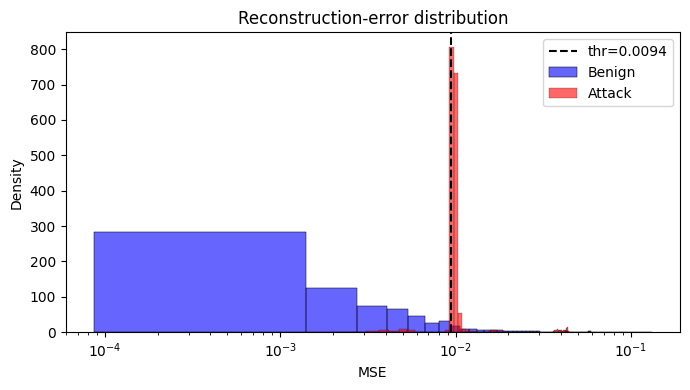

In [296]:
"""
This block is ran after model is tuned using validation set.
"""

with open("best_threshold.pkl", "rb") as f:
    best_thr = pickle.load(f)

print(f"best thr: {best_thr}")

auto_loaded = models.load_model("denoising_autoencoder_model.h5", compile=False)

test_err = np.mean((auto_loaded.predict(X_test) - X_test) ** 2, axis=1)
y_pred = (test_err > best_thr).astype(int)

# Classification report
print("\nClassification Report (Benign = 0, Attack = 1):")
print(classification_report(y_test_bin, y_pred, digits=3))

# Confusion matrix
conf_mat = confusion_matrix(y_test_bin, y_pred)
conf_df = pd.DataFrame(
    conf_mat,
    index=["Actual: Benign (0)", "Actual: Attack (1)"],
    columns=["Predicted: Benign (0)", "Predicted: Attack (1)"]
)
print("\nReadable Confusion Matrix:")
print(conf_df)

# Plot
plt.figure(figsize=(7, 4))
sns.histplot(test_err[y_test_bin == 0], bins=100, stat="density",
             label="Benign", color="blue", alpha=0.6)
sns.histplot(test_err[y_test_bin == 1], bins=100, stat="density",
             label="Attack", color="red", alpha=0.6)
plt.axvline(best_thr, ls="--", c="k", label=f"thr={best_thr:.2g}")
plt.xscale("log")
plt.legend()
plt.title("Reconstruction-error distribution")
plt.xlabel("MSE")
plt.tight_layout()
plt.show()